# Plant Seedlings Classification
- The goal of the competition is to create a classifier capable of determining a plant's species from a photo.
- [Plant Seedlings Classification], https://www.kaggle.com/c/plant-seedlings-classification/overview
- Train accuracy: 72.50%, Val accuracy: 69.38%
    
### Reference
- [coding-practice by osterburg], 'https://github.com/osterburg/coding-practice'    

## 0. Import Packages

In [101]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import tarfile
import glob
from six.moves import urllib
import random
import shutil
from PIL import Image
import imageio
from PIL import Image, ImageOps
# from scipy.misc import imresize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import load_model
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

## 1. Load Dataset
- Convert PNG to JPG

In [16]:
def convert_jpg(dir, save_dir):
    
    data = []
    cat_list = os.listdir(dir)
    cat_len = len(os.listdir(dir))
    
    for cat in cat_list :
        
        category = os.listdir(dir + cat)
        i = 0
        for name in category :
            png = imageio.imread(dir + cat + '/' + name)
            png = Image.fromarray(png)
            png.load()  # for splitting

            # convert RGBA to RGB -> alpha channel
            if(len(png.split()) == 4):
                img = Image.new('RGB', png.size, (255, 255, 255)) # white
                img.paste(png, mask = png.split()[3])
            else:
                img = png

            img.save(save_dir + cat + '/' + str(i) + '.jpg')
            i += 1

In [17]:
dir = "train/"
cat_list = os.listdir(dir)
cat_len = len(os.listdir(dir))

print("The number of category :",cat_len)
print(cat_list)

The number of category : 12
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [2]:
# Convert png to jpg
dir = "train/"
save_dir = "train_jpg/"
convert_jpg(dir, save_dir)

## 2. Explore Dataset

In [32]:
def load_data_files(base_dir):
    folder_name = "train_jpg"
    RAW_DATASET = os.path.join(base_dir, folder_name)

    abs_dir = os.path.join(os.getcwd(), folder_name)
    sub_dir = os.listdir(abs_dir)
    data_dic = {}
    cat_len = []
    for class_name  in sub_dir:
        imgs = glob(os.path.join(RAW_DATASET,class_name,"*.jpg"))

        data_dic[class_name] = imgs
        cat_len.append(len(imgs))
        print("Class: {}".format(class_name))
        print("Number of images: {} \n".format(len(imgs)))

    return data_dic, cat_len

In [33]:
BASE_DIR = os.getcwd()
data_dic, cat_len = load_data_files(BASE_DIR)

Class: Black-grass
Number of images: 263 

Class: Charlock
Number of images: 390 

Class: Cleavers
Number of images: 287 

Class: Common Chickweed
Number of images: 611 

Class: Common wheat
Number of images: 221 

Class: Fat Hen
Number of images: 475 

Class: Loose Silky-bent
Number of images: 654 

Class: Maize
Number of images: 221 

Class: Scentless Mayweed
Number of images: 516 

Class: Shepherds Purse
Number of images: 231 

Class: Small-flowered Cranesbill
Number of images: 496 

Class: Sugar beet
Number of images: 385 



In [63]:
def plot_image_grid(images_files):
    # figure size
    fig = plt.figure(figsize = (8, 8))

    # load images
    images = [tf.keras.preprocessing.image.load_img(img) for img in images_files]

    # plot image grid
    for x in range(4):
        ax = fig.add_subplot(1, 4, x+1)
        plt.imshow(images[x])
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

Seed type: Black-grass


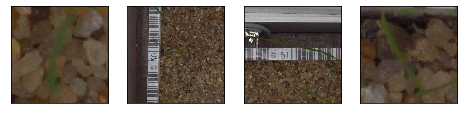

Seed type: Charlock


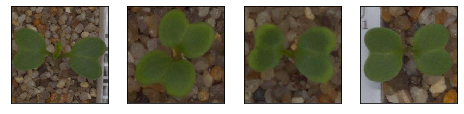

Seed type: Cleavers


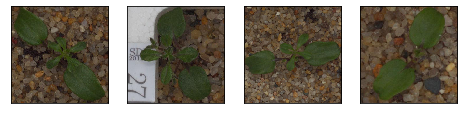

Seed type: Common Chickweed


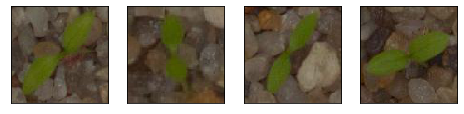

Seed type: Common wheat


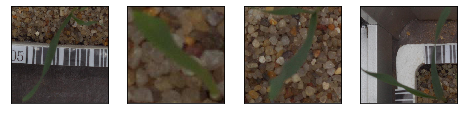

Seed type: Fat Hen


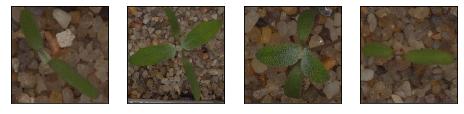

Seed type: Loose Silky-bent


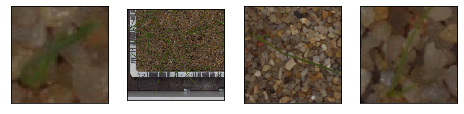

Seed type: Maize


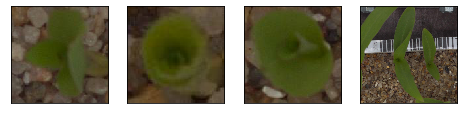

Seed type: Scentless Mayweed


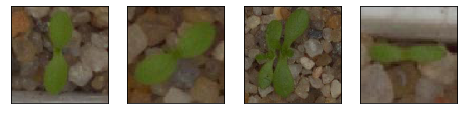

Seed type: Shepherds Purse


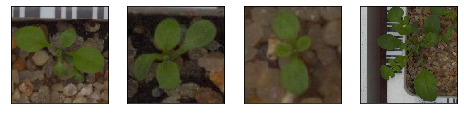

Seed type: Small-flowered Cranesbill


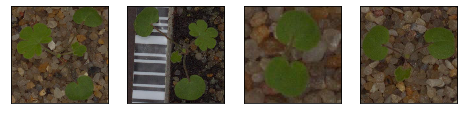

Seed type: Sugar beet


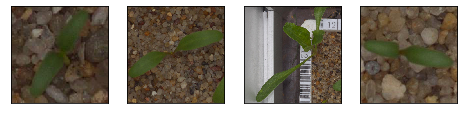

In [65]:
for class_name, imgs in data_dic.items():
    print("Seed type: {}".format(class_name))
    plot_image_grid(imgs[:16])

##  3. Make Dataset

In [50]:
# Create new directory and copy files to it
def copy_files_to_directory(files, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created directory: {}".format(directory))

    for f in files:
        shutil.copy(f, directory)
    print("Copied {} files.\n".format(len(files)))

In [51]:
def train_validation_split(base_dir, data_dic, split_ratio=0.2):
    FLOWER_DATASET = os.path.join(base_dir,"train_jpg")

    if not os.path.exists(FLOWER_DATASET):
        os.makedirs(FLOWER_DATASET)

    for class_name, imgs in data_dic.items():
        idx_split = int(len(imgs) * split_ratio)
        random.shuffle(imgs)
        validation = imgs[:idx_split]
        train = imgs[idx_split:]

        copy_files_to_directory(train, os.path.join(FLOWER_DATASET,"train",class_name))
        copy_files_to_directory(validation, os.path.join(FLOWER_DATASET,"validation",class_name))

In [52]:
BASE_DIR = os.getcwd()

train_validation_split(BASE_DIR, data_dic, split_ratio = 0.2)

Created directory: C:\Users\오서영\Desktop\동아리\과제\1기_kaggle 과제 3 - Plant Seedlings Classification\train_jpg\train\Black-grass
Copied 211 files.

Created directory: C:\Users\오서영\Desktop\동아리\과제\1기_kaggle 과제 3 - Plant Seedlings Classification\train_jpg\validation\Black-grass
Copied 52 files.

Created directory: C:\Users\오서영\Desktop\동아리\과제\1기_kaggle 과제 3 - Plant Seedlings Classification\train_jpg\train\Charlock
Copied 312 files.

Created directory: C:\Users\오서영\Desktop\동아리\과제\1기_kaggle 과제 3 - Plant Seedlings Classification\train_jpg\validation\Charlock
Copied 78 files.

Created directory: C:\Users\오서영\Desktop\동아리\과제\1기_kaggle 과제 3 - Plant Seedlings Classification\train_jpg\train\Cleavers
Copied 230 files.

Created directory: C:\Users\오서영\Desktop\동아리\과제\1기_kaggle 과제 3 - Plant Seedlings Classification\train_jpg\validation\Cleavers
Copied 57 files.

Created directory: C:\Users\오서영\Desktop\동아리\과제\1기_kaggle 과제 3 - Plant Seedlings Classification\train_jpg\train\Common Chickweed
Copied 489 files.

C

In [114]:
# params
batch_size = 32
num_classes = 12
epochs = 50

In [71]:
preprocessing_image = tf.keras.preprocessing.image

train_datagen = preprocessing_image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = preprocessing_image.ImageDataGenerator(rescale=1./255)

In [72]:
BASE_DIR = os.getcwd()

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "train_jpg/train"),
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "train_jpg/validation"),
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='categorical')

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


## 4-1. Baseline CNN

In [157]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='same',
                 activation='relu',
                 input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 32)        51232     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)             

## 4-2. Add layers to CNN

In [237]:
model2 = Sequential()
model2.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                 activation='relu',
                 input_shape=(32, 32, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(65, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))
model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 32)          4640      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 4, 4, 65)        

In [238]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [1]:
%%time
hist50 = model.fit_generator(
    train_generator,
    steps_per_epoch=3803//batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=20)

In [169]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Baseline CNN Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Baseline CNN loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

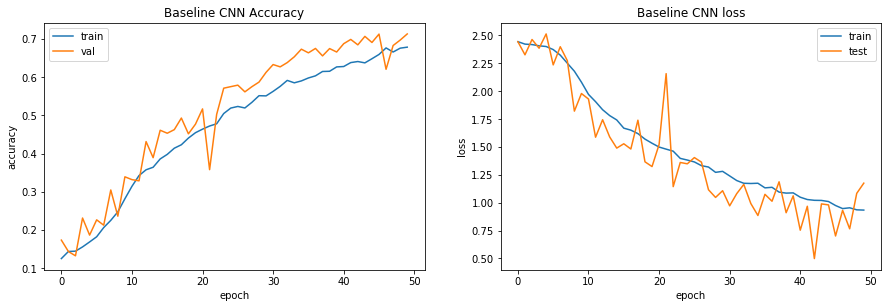

In [170]:
plot_accuracy_and_loss(hist50)

In [171]:
print("-- Evaluate --")

scores_train = model2.evaluate_generator(
            train_generator, 
            steps = 5)
scores_val = model2.evaluate_generator(
            validation_generator, 
            steps = 5)

print("Train " + "%s: %.2f%%" %(model2.metrics_names[1], scores_train[1]*100))
print("Val " + "%s: %.2f%%" %(model2.metrics_names[1], scores_val[1]*100))

print("-- Predict --")
output_train = model2.predict_generator(train_generator, steps=5)
output_val = model2.predict_generator(validation_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(train_generator.class_indices)
print(output_train)

print(validation_generator.class_indices)
print(output_val)

-- Evaluate --
Train accuracy: 72.50%
Val accuracy: 69.38%
-- Predict --
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
[[0.000 0.000 0.000 ... 0.001 0.995 0.003]
 [0.617 0.000 0.001 ... 0.000 0.000 0.001]
 [0.001 0.064 0.060 ... 0.017 0.002 0.380]
 ...
 [0.000 0.011 0.040 ... 0.016 0.021 0.001]
 [0.395 0.000 0.000 ... 0.000 0.000 0.001]
 [0.000 0.001 0.004 ... 0.001 0.001 0.835]]
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
[[0.000 0.076 0.003 ... 0.543 0.194 0.000]
 [0.011 0.003 0.178 ... 0.002 0.001 0.161]
 [0.000 0.043 0.011 ... 0.142 0.012 0.054]
 ...
 [0.020 0.064 0.598 ... 0.003 0.002 0.038]
 [0.000 0.00

In [172]:
# save model architecture
model_json = model2.to_json()
open('4layer_cnn_with_50iterations.json', 'w').write(model_json)

# save model's learned weights
model2.save_weights('4layer_cnn_weights_with_50iterations.h5', overwrite=True)

In [220]:
# Load trained model
from keras.models import model_from_json 

json_file = open("baseline_cnn_with_10iterations.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)
 
# model weight load 
loaded_model.load_weights("baseline_cnn_weights_with_10iterations.h5")
print("Loaded model from disk")

Loaded model from disk


## 5. Submission

In [226]:
z = glob.glob('test/*.png')
test_imgs = []
names = []
for fn in z:
    if fn[-3:] != 'png':
        continue
    names.append(fn.split('test\\')[-1])
#     print(names)
    new_img = Image.open(fn)
    test_img = ImageOps.fit(new_img, (32,32), Image.ANTIALIAS).convert('RGB')
    test_imgs.append(test_img)

In [227]:
test_img = np.array([np.array(im) for im in test_imgs])
test_x = test_img.reshape(test_img.shape[0], 32, 32, 3) / 255

test_x.shape

(794, 32, 32, 3)

In [228]:
lb = LabelBinarizer().fit(names)

pred = loaded_model2.predict(test_x)
# print(pred)
prediction = lb.inverse_transform(pred)

In [229]:
df = pd.DataFrame(data={'file': names, 'species': prediction})
df_sort = df.sort_values(by=['file'])
df_sort.to_csv('CNN_with_50iterations.csv', index=False)